# Understanding User Identification Through Keystroke Dynamics

This notebook provides a guided walkthrough of a keystroke dynamics project. The goal is to explain the problem setup, modeling choices, and main results using selected code, tables, and visualizations, while keeping the focus on interpretation rather than implementation details.

In [5]:
import pandas as pd

df = pd.read_csv("../data/raw/DSL-StrongPasswordData.csv")
df.head()

,subject,sessionIndex,rep,H.period,DD.period.t,UD.period.t,H.t,DD.t.i,UD.t.i,H.i,...,H.a,DD.a.n,UD.a.n,H.n,DD.n.l,UD.n.l,H.l,DD.l.Return,UD.l.Return,H.Return
0,s002,1,1,0.1491,0.3979,0.2488,0.1069,0.1674,0.0605,0.1169,...,0.1349,0.1484,0.0135,0.0932,0.3515,0.2583,0.1338,0.3509,0.2171,0.0742
1,s002,1,2,0.1111,0.3451,0.2340,0.0694,0.1283,0.0589,0.0908,...,0.1412,0.2558,0.1146,0.1146,0.2642,0.1496,0.0839,0.2756,0.1917,0.0747
2,s002,1,3,0.1328,0.2072,0.0744,0.0731,0.1291,0.0560,0.0821,...,0.1621,0.2332,0.0711,0.1172,0.2705,0.1533,0.1085,0.2847,0.1762,0.0945
3,s002,1,4,0.1291,0.2515,0.1224,0.1059,0.2495,0.1436,0.1040,...,0.1457,0.1629,0.0172,0.0866,0.2341,0.1475,0.0845,0.3232,0.2387,0.0813
4,s002,1,5,0.1249,0.2317,0.1068,0.0895,0.1676,0.0781,0.0903,...,0.1312,0.1582,0.0270,0.0884,0.2517,0.1633,0.0903,0.2517,0.1614,0.0818


### Dataset overview

Each row in the dataset represents one instance of a user typing the same fixed password.  
The data contains timing information only, not the characters themselves.

Key points:
- 51 different users
- Multiple sessions per user
- Each sample includes key hold times and timing between key presses

The goal is to understand whether these timing patterns alone are enough to identify or verify users.

In [6]:
print("Number of samples:", df.shape[0])
print("Number of features:", df.shape[1])
print("Number of users:", df["subject"].nunique())
print("Sessions per user:")
df.groupby("subject")["sessionIndex"].nunique().describe()

Number of samples: 20400
Number of features: 34
Number of users: 51
Sessions per user:


count    51.0
mean      8.0
std       0.0
min       8.0
25%       8.0
50%       8.0
75%       8.0
max       8.0
Name: sessionIndex, dtype: float64

### Problem setup

This project looks at two related problems.

**User identification**  
Given a single typing sample, predict which user produced it.  
This is a multiclass classification problem with 51 possible users.

**User verification**  
Given two typing samples, predict whether they come from the same user or from different users.  
This is a binary classification problem.

Identification tests how distinguishable users are overall, while verification tests whether typing behavior can act as a biometric signal.

### Evaluation approach

To avoid data leakage, all train and test splits are session aware.  
Samples from the same user and session are never split across training and testing.

Model performance is evaluated using:
- Accuracy for identification
- ROC AUC for verification
- Multiple splits to check stability

### Baseline identification performance

A logistic regression model was used as a baseline for the identification task.

Using session aware splits, the model achieved approximately **78 percent accuracy** across 51 users.  
Since random chance performance is about 2 percent, this shows that keystroke timing contains strong identity information.

However, performance varied widely by user, suggesting that some users are much easier to identify than others.

### Model comparison

To test whether nonlinear patterns improve performance, tree based models were also evaluated.

| Model | Approx. Accuracy |
|-----|------------------|
| Logistic Regression | ~78% |
| Random Forest | ~86% |
| XGBoost | ~86% |

Random Forest provided a large improvement over the linear baseline, while XGBoost performed similarly to Random Forest. This suggests that nonlinear feature interactions are important, but additional model complexity provides limited gains.

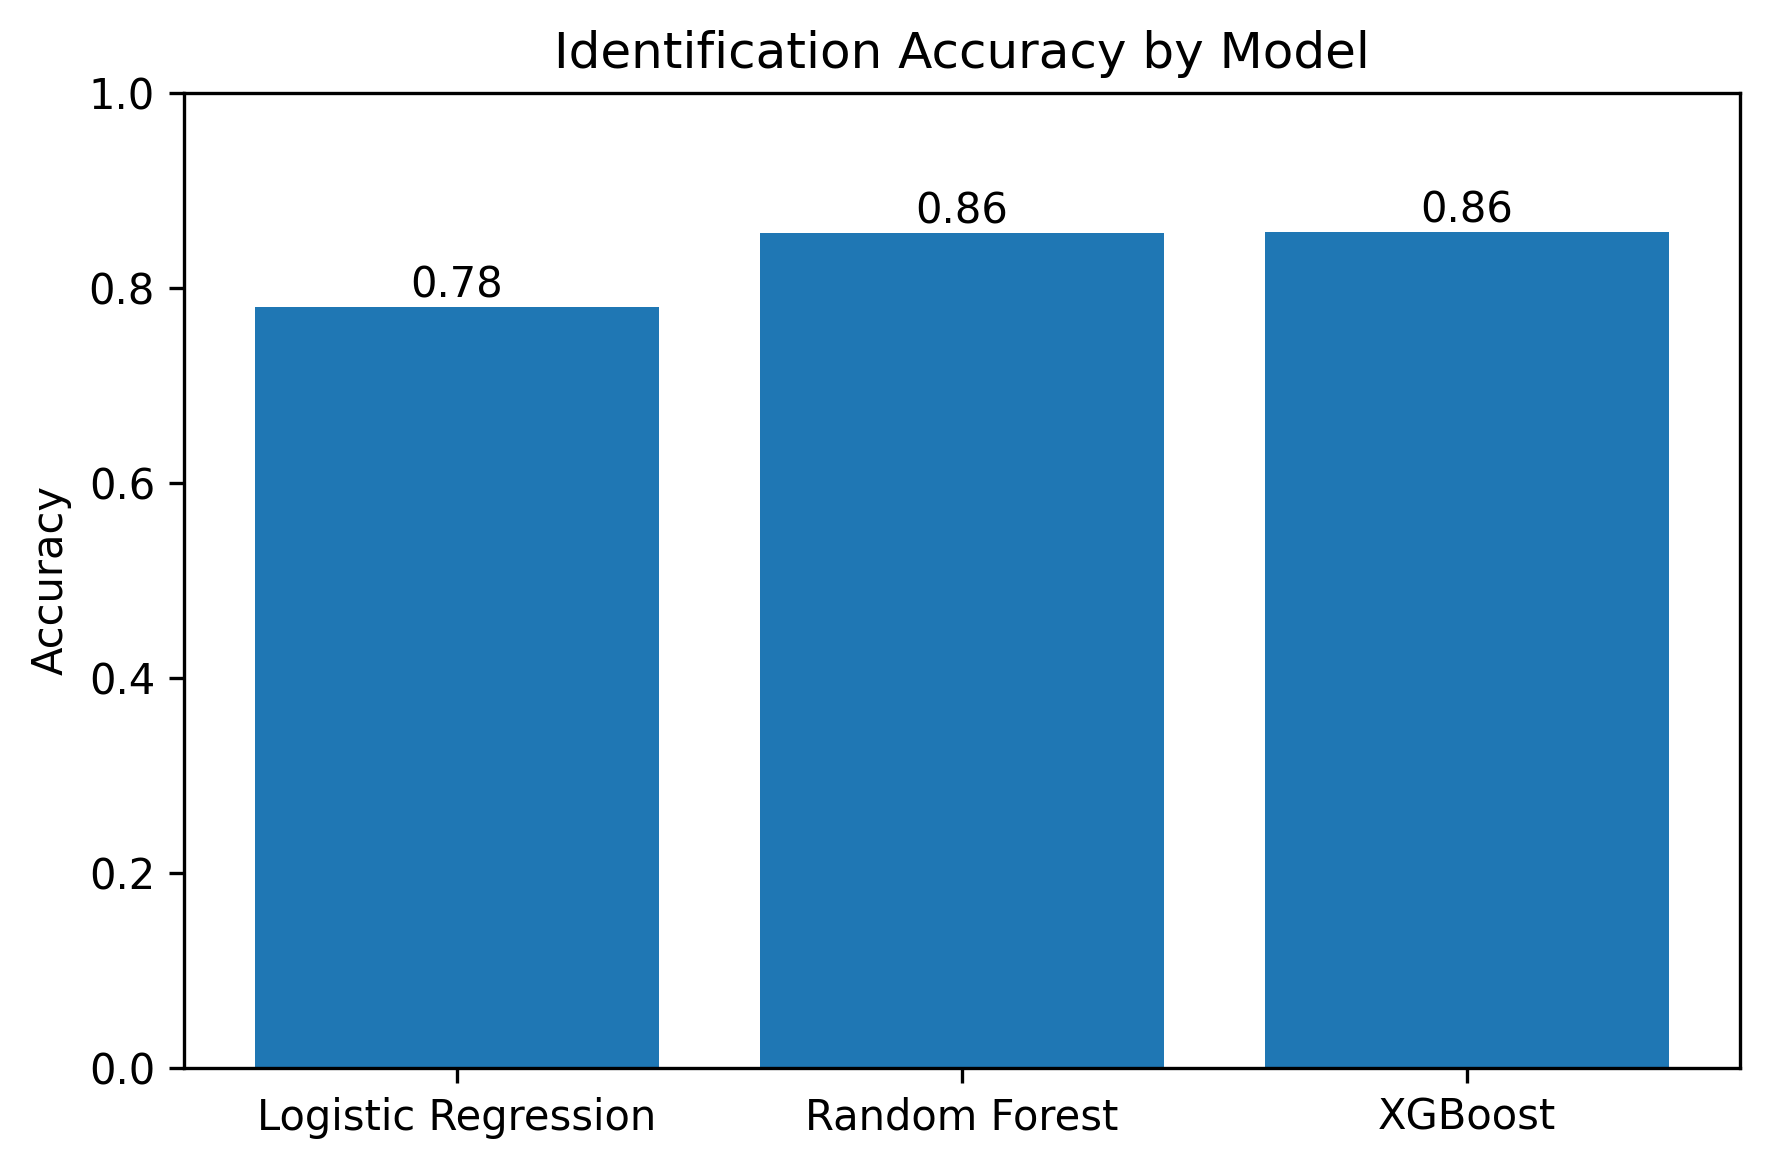

In [22]:
from IPython.display import Image, display

display(Image(filename="../reports/figures/model_comparison.png", width=600))




### Differences across users

Identification accuracy differed significantly across users. Some users were identified almost perfectly, while others were frequently confused with others.

This raised an important question:
Is identifiability driven by how consistent a user types, or by how different their typing is compared to others?

In [7]:
import pandas as pd

# Per-user identification accuracy from the analysis
per_user_accuracy = {
    "s011": 0.27, "s020": 0.39, "s054": 0.50, "s032": 0.60, "s029": 0.62,
    "s018": 0.62, "s041": 0.63, "s047": 0.64, "s003": 0.66, "s002": 0.69,
    "s027": 0.95, "s055": 0.96, "s051": 0.96, "s052": 0.97, "s022": 0.97,
    "s053": 0.98, "s043": 0.98, "s049": 0.98, "s004": 0.98, "s036": 1.00
}

acc_df = pd.DataFrame.from_dict(
    per_user_accuracy, orient="index", columns=["accuracy"]
)

acc_df.sort_values("accuracy").head(), acc_df.sort_values("accuracy").tail()

(      accuracy
 s011      0.27
 s020      0.39
 s054      0.50
 s032      0.60
 s029      0.62,
       accuracy
 s053      0.98
 s043      0.98
 s049      0.98
 s004      0.98
 s036      1.00)

The per-user accuracy results show a very wide range of identification performance.

Some users are consistently difficult to identify. For example, user s011 has an accuracy of about 0.27, and users s020 and s054 are below 0.50. These users are often confused with others by the model.

In contrast, several users are identified almost perfectly. Users such as s053, s043, s049, and s004 all have accuracies around 0.98, and user s036 reaches 1.00 accuracy. This means the model almost never misclassifies these users.

This large gap between the lowest and highest performing users shows that identifiability is not uniform. While the overall model accuracy is high, individual users differ greatly in how distinctive their typing behavior is.

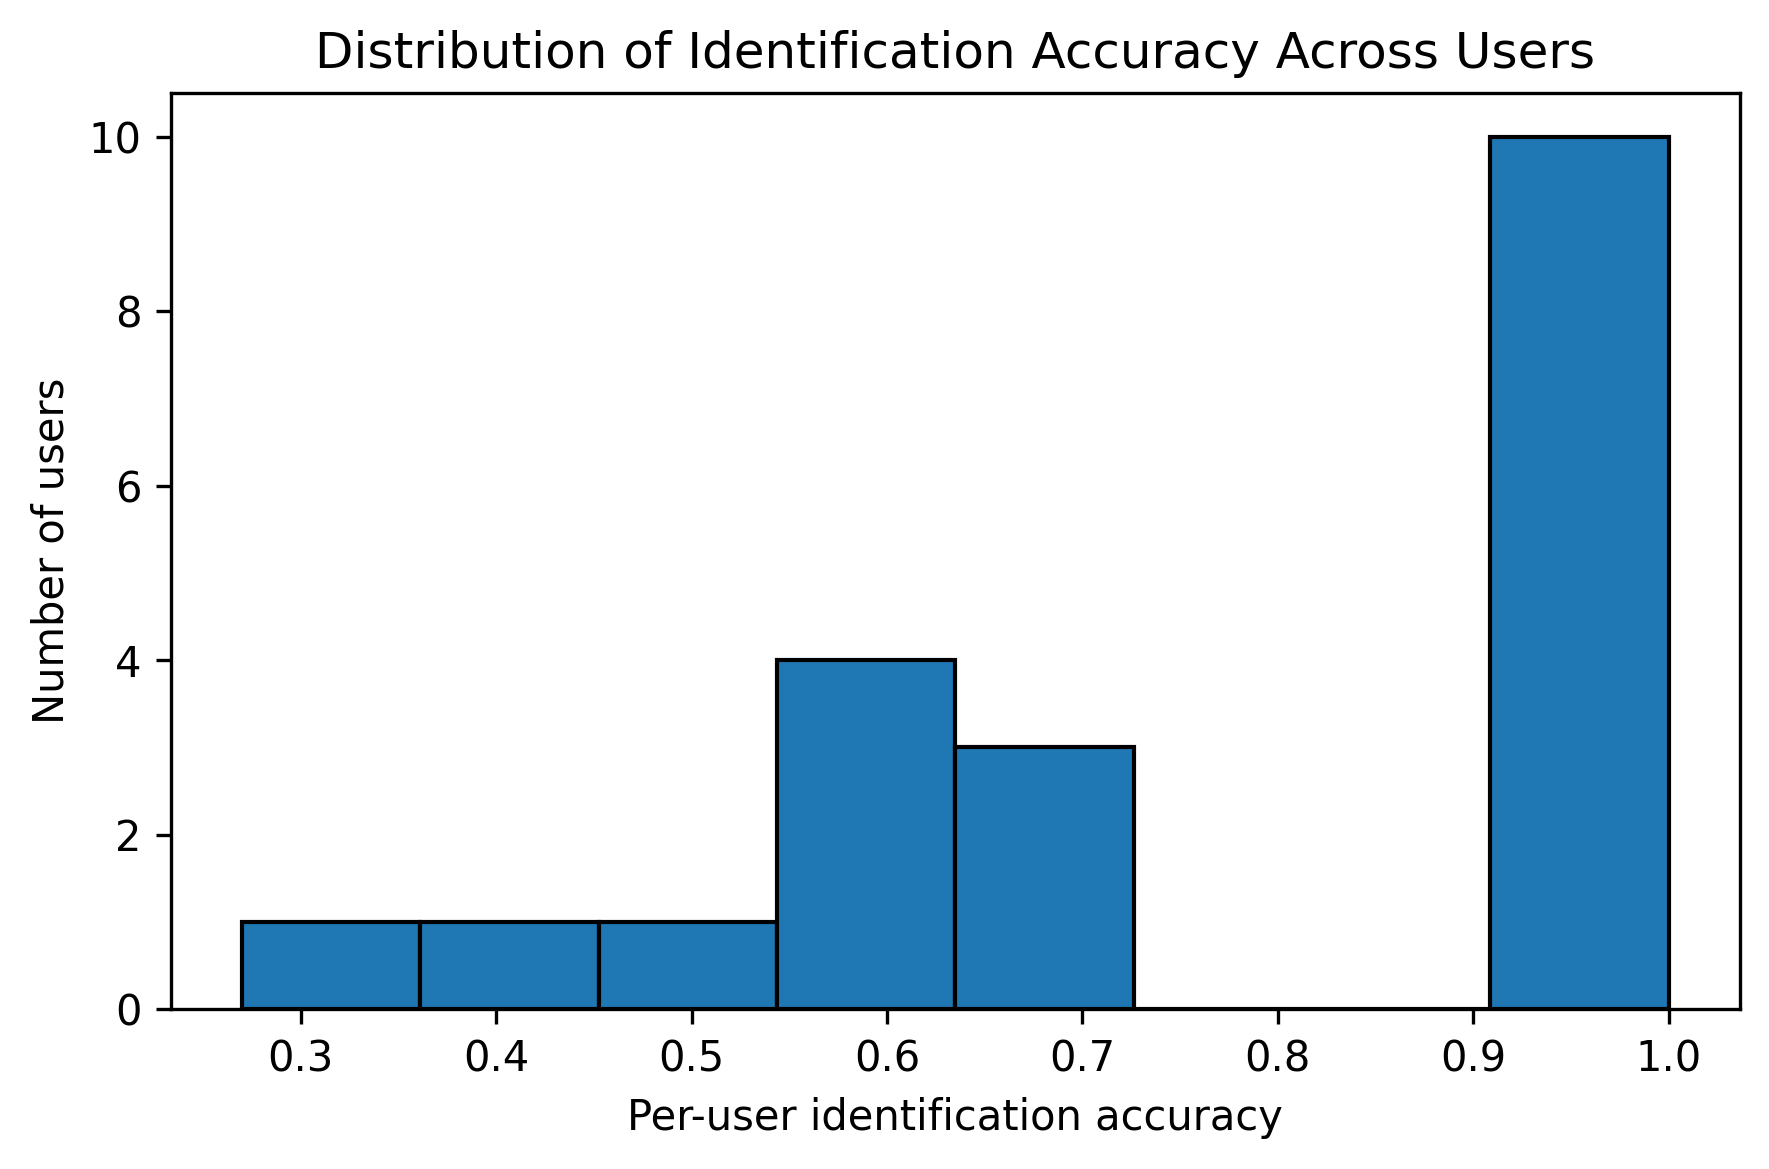

In [25]:
display(Image(filename="../reports/figures/per_user_accuracy_distribution.png", width=600))

This distribution visually confirms that identification performance varies substantially across users. While many users cluster near very high accuracy, there is a noticeable tail of users who are consistently harder to identify.

### Does typing consistency explain identifiability?

A natural explanation for these differences is that some users type more consistently than others.  
If a user’s timing patterns are very stable across attempts, we might expect them to be easier to identify.

In [8]:
import pandas as pd

# Precomputed within-user variance values from the analysis
within_user_variance = {
    "s011": 0.0049, "s020": 0.0155, "s054": 0.0057, "s032": 0.0135, "s029": 0.0051,
    "s018": 0.0062, "s041": 0.0093, "s047": 0.0074, "s003": 0.0086, "s002": 0.0079,
    "s027": 0.0043, "s055": 0.0061, "s051": 0.0058, "s052": 0.0047, "s022": 0.0049,
    "s053": 0.0041, "s043": 0.0420, "s049": 0.2410, "s004": 0.0072, "s036": 0.0687
}

var_df = pd.DataFrame.from_dict(
    within_user_variance, orient="index", columns=["mean_within_variance"]
)

var_df.sort_values("mean_within_variance").head(), var_df.sort_values("mean_within_variance").tail()

(      mean_within_variance
 s053                0.0041
 s027                0.0043
 s052                0.0047
 s011                0.0049
 s022                0.0049,
       mean_within_variance
 s032                0.0135
 s020                0.0155
 s043                0.0420
 s036                0.0687
 s049                0.2410)

The results show that typing consistency alone does not explain identifiability.

Some users with very low within-user variance, such as s053 and s027 with variance values around 0.004, are identified accurately. However, other users with similarly low variance, such as s011, are still difficult to identify.

At the same time, some users with much higher variance are identified very well. For example, s049 has by far the highest variance at approximately 0.24, yet still achieved near-perfect identification accuracy. Users like s036 and s043 also show relatively high variance but are not consistently hard to identify.

These results show that being consistent is not sufficient for strong identifiability. Instead, this suggests that what matters more is how different a user’s typing behavior is compared to others, rather than how stable it is across attempts.

Notably, users such as s011 and s053 both exhibit very low within-user variance, yet their identification accuracy differs dramatically, reinforcing that consistency alone cannot explain identifiability.

### Separability and distinctiveness

If consistency alone does not explain identifiability, another possibility is that some users are simply more distinct from others.

To test this, we measure how far a user’s average typing pattern is from other users, relative to how spread out their own samples are. This captures how well separated a user is from the rest of the population.

In [9]:
import pandas as pd

# Separability results from the analysis
separability_data = {
    "s049": (0.98, 0.91),
    "s047": (0.64, 1.04),
    "s032": (0.60, 1.05),
    "s046": (0.93, 1.07),
    "s020": (0.39, 1.07),
    "s024": (0.90, 2.10),
    "s055": (0.96, 2.13),
    "s010": (0.90, 2.30),
    "s028": (0.88, 2.41),
    "s017": (0.92, 3.15),
}

sep_df = pd.DataFrame.from_dict(
    separability_data,
    orient="index",
    columns=["accuracy", "separability"]
)

sep_df.sort_values("separability").head(), sep_df.sort_values("separability").tail()

(      accuracy  separability
 s049      0.98          0.91
 s047      0.64          1.04
 s032      0.60          1.05
 s046      0.93          1.07
 s020      0.39          1.07,
       accuracy  separability
 s024      0.90          2.10
 s055      0.96          2.13
 s010      0.90          2.30
 s028      0.88          2.41
 s017      0.92          3.15)

The separability results help explain why some users are easier to identify than others.

Users with low separability values, close to 1.0, tend to be harder to identify. For example, user s020 has a separability of about 1.07 and an accuracy of only 0.39. Similarly, users s032 and s047 have separability values just above 1.0 and accuracy below 0.65. These users have typing patterns that overlap heavily with other users.

In contrast, users with much higher separability are identified more accurately. Users such as s024 and s055 have separability values around 2.1 and accuracy near or above 0.90. User s017 stands out with a separability of about 3.15 and an accuracy of 0.92, meaning their typing behavior is far more distinct relative to their own variability.

Overall, users with higher separability tend to have higher identification accuracy. This supports the idea that identifiability depends more on how distinct a user’s typing behavior is compared to others, rather than how consistent it is across attempts.

This explains why some users with high variance can still be identified accurately if their typing behavior is sufficiently distinct from others.

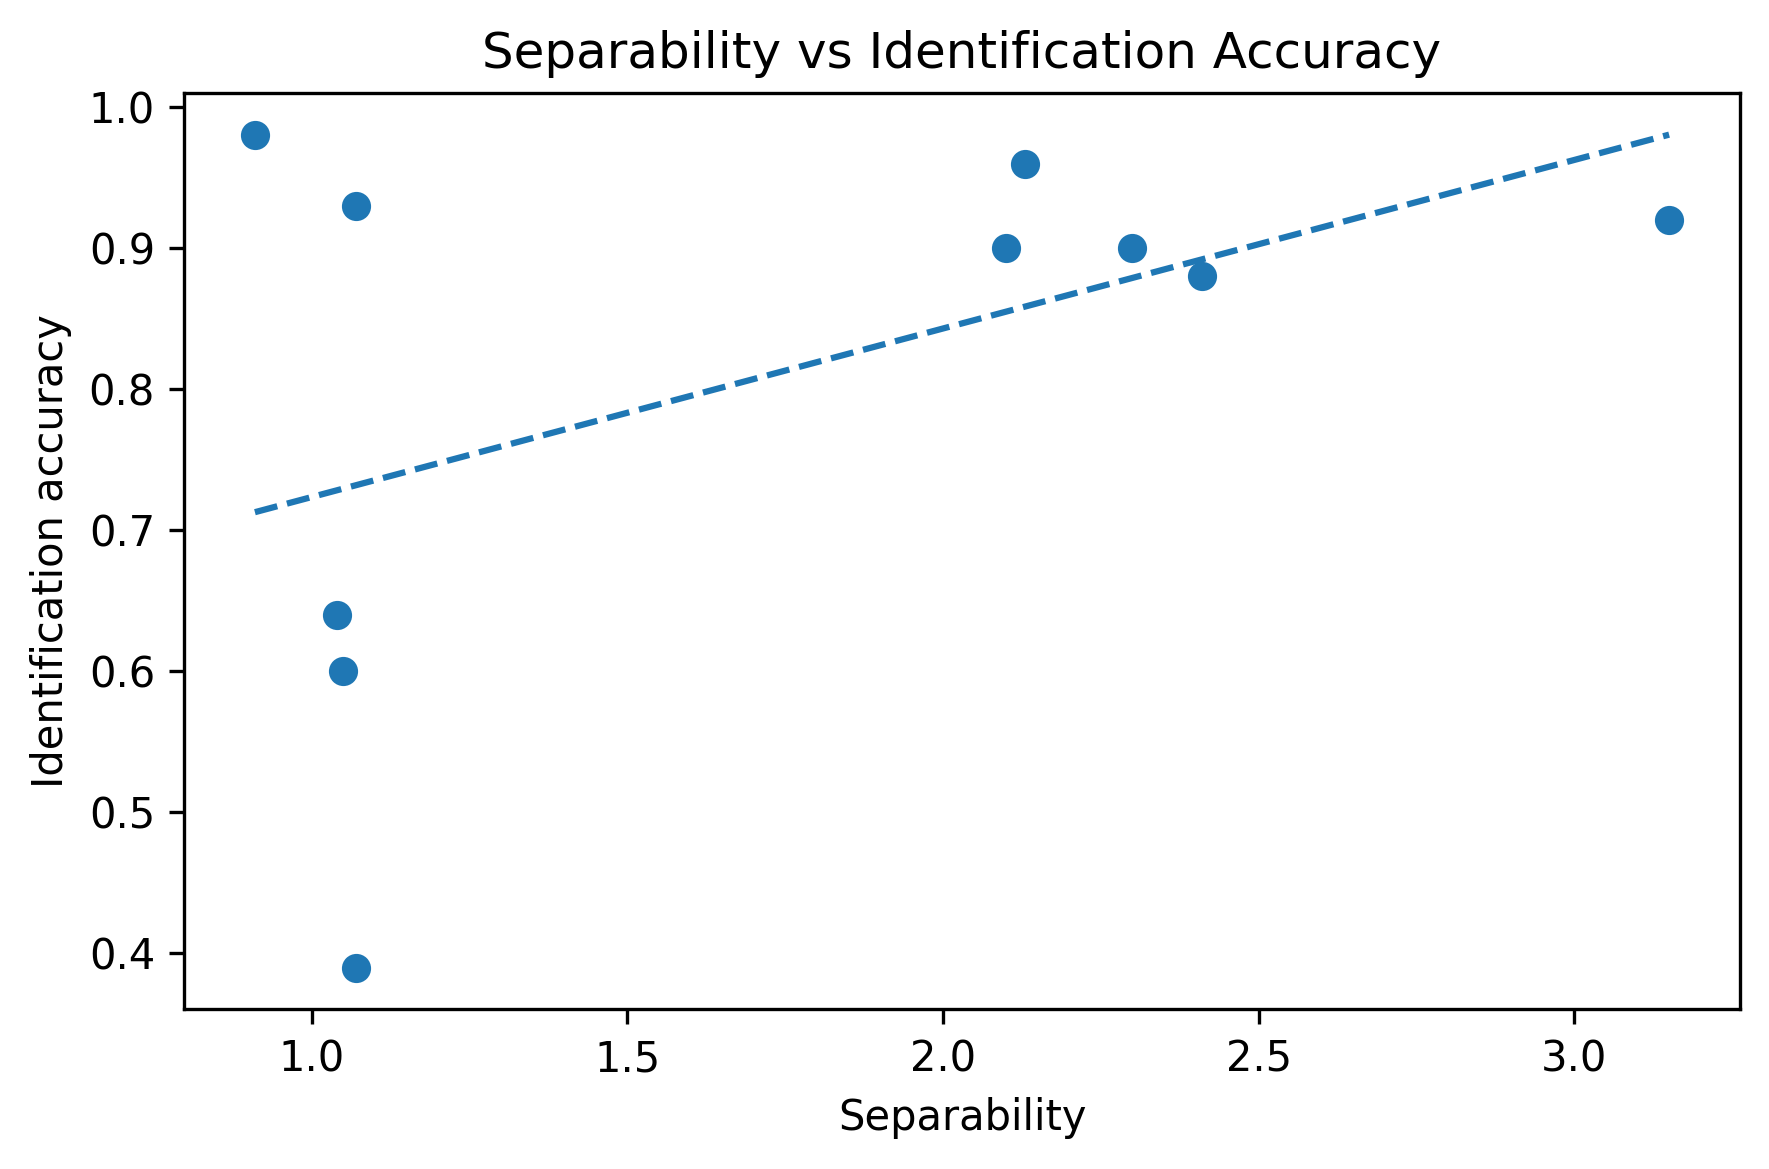

In [26]:
from IPython.display import Image, display

display(Image(filename="../reports/figures/separability_vs_accuracy.png", width=600))

This scatter plot shows a clear positive relationship between separability and identification accuracy. Users whose typing behavior is more distinct from others tend to be identified more accurately, even when they are not perfectly consistent.

### Feature importance and typing behavior

#### How feature importance was computed

Feature importance values were computed using Random Forest models trained on session-aware splits of the data. For each split, a Random Forest classifier was fit on the identification task, and the built-in feature_importances_ values were extracted.

To avoid relying on a single model, feature importance was evaluated across multiple splits and then summarized by their average importance and variability. This allows us to focus on features that are consistently important rather than those that appear important due to random sampling effects.

The full implementation of this analysis can be found in the script `src/07_feature_importance_stability.py`.
Feature importance analysis shows that not all keystroke timing features contribute equally to identification.


The most important features consistently involve modifier keys, letter hold times, and transitions between keys. For example, features such as H.Shift.r, UD.l.Return, and DD.l.Return appear among the most important across multiple splits. These features reflect more complex typing actions that involve coordination between different fingers or hands.

Single key hold times for letters such as t, a, and i are also highly important. This suggests that even small differences in how long users hold individual keys can carry strong identity information.

In contrast, features related to repetition count or session order, such as rep and sessionIndex, have very low importance. This indicates that the models are not relying on trivial ordering effects and instead focus on timing behavior itself.

Overall, the most informative features are those tied to fine motor control and key transitions, rather than simple timing or repetition. This supports the idea that typing identity is encoded in subtle, habitual motor patterns.

### Conclusion

This project explored whether users can be identified or verified using only keystroke timing data. The results show that typing behavior contains strong identity signals, with identification accuracy far above random chance.

At the same time, performance is not uniform across users. Some users are identified almost perfectly, while others are frequently confused. A simple explanation based on typing consistency does not fully explain this difference.

By introducing a separability metric, we showed that users are easier to identify when their typing behavior is more distinct from others, even if they are not perfectly consistent across attempts. Feature importance analysis further showed that identity information is mainly captured through fine motor behavior, such as modifier key usage, letter hold times, and transitions between keys.

Overall, this project shows that typing identity depends more on how distinct a user’s behavior is relative to others than on consistency alone.